In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Housekeeping and Data Preparation

In [3]:
def load_data(filepath):
    """Loads in original data from the CSV file contained in the location given by
    filepath.

    params:

    :filepath: a string containing the path to the data-containing CSV.

    returns: 
    
    :df: the original CSV file just so that we don't have to load it every time"""
    
    df = pd.read_csv(filepath)

    return  df
#enter your data directory in a format like 'c:/abc/def/2019_data.csv'
df=load_data('c:/abc/def/2019_data.csv') 

In [4]:
def df_preparation(df):
    """The original dataframe has athlete names with variables and values in two different columns for each date throughout 
    the year. What we need is to have names with variables (aka features) each in one column and values in rows. Therefore,
    the original file is pivoted accordingly.

    params:

    :df: the original data read from CSV file

    returns: 
    
    :dataset: a dataframe with the columns that we need"""
    
    # First remove any variables that are of no interest.
    #Trivial correlated features such as Scoring|Points|POINTS|won|Won|SCORE|FedExCup are removed from the analysis. 
    
    dftotes=df[df['Variable'].str.contains("Driving|Putting|Distance|Accuracy|Drive|Putt|Money")]
    dftotes=dftotes[~dftotes['Variable'].str.contains("FedExCup")]
    
    # Then pivot the dataframe so that we have features in columns
    df_sorted=dftotes.pivot_table(
            values='Value', 
            index=['Player Name'], 
            columns='Variable', 
            aggfunc='first')

    dataset = df_sorted
    
    # Our target is the 'Official Money - (MONEY)' which has $ and , so needs to be cleaned up. First we drop NaNs
    dataset['Official Money - (MONEY)']=dataset['Official Money - (MONEY)'].replace(to_replace='None', value=np.nan).dropna()
    dataset = dataset[pd.notnull(dataset['Official Money - (MONEY)'])]
    # Then we convert moneys to numbers
    dataset['Official Money - (MONEY)'] = dataset['Official Money - (MONEY)'].fillna(0.0).str.replace('[$,]', '').astype('float')  

    return  dataset
dataset=df_preparation(df)

d:\Users\Cyrus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
def drop_nan_cols(dataset,drop_threshold): 
    """If a feature is not available for at least 50% of athletes, that
    feature is not used in analyses.
    
    params:

    :dataset: a Pandas DataFrame as loaded by the load_data() function.
    :drop_threshold: the number of NaN entries above which we remove a column
    from the dataset (considering the dataset has 265 entries, this threshold is
    taken as 130 meaning at a variable data should be available for at least 50% 
    of athletes)

    returns: 
    
    :reduced_dataset: (the dataset taken as input, with any columns
    containing more than drop_threshold NaN entries dropped)."""
    
    #dataset=dataset.applymap(lambda x: np.nan if x=='?' else x)
    reduced_dataset=dataset.drop(dataset.isnull().sum().gt(drop_threshold)[lambda x: x].index , axis='columns')

    return  reduced_dataset
reduced_dataset=drop_nan_cols(dataset,drop_threshold=130)

In [6]:
def change_obj_to_int(inputs):
    """Converts the columns with object type, into int type, which it needs 
    to be in order to be fed into the downstream learning algorithm.

    params:

    :inputs: a Pandas DataFrame that contains the inputs that will be taken in
    by the downstream learning algorithm.

    returns: 
    
    :inputs: a Pandas DataFrame with no obj type"""
    
    inputs['Official Money - (MONEY)']=inputs['Official Money - (MONEY)'].astype(int)
    for col in inputs.columns[inputs.dtypes=='object']:
        inputs[col] = pd.to_numeric(inputs[col], errors='coerce')
    return inputs 
reduced_dataset=change_obj_to_int(reduced_dataset)

In [7]:
def split_train_and_test(dataset,test_frac=0.25):
    """Splits the input dataset into randomly-shuffled training and testing
    sets.

    params:

    :dataset: a Pandas DataFrame containing the total dataset, which is to be
    split into training and testing components.
    :test_frac: the fraction of samples to be reserved for testing.

    returns: 
    
    :X_train, X_test, y_train, y_test: the splitted training and testing sets as
    Pandas DataFrames.
    :X, y: prepared dataframes prior to splitting (for debugging purposes mostely)"""
    
    from sklearn.model_selection import train_test_split
    
    X=dataset[list(set(list(dataset.columns))-set(['Official Money - (MONEY)']))]
    y=dataset['Official Money - (MONEY)']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    return X_train, X_test, y_train, y_test, X, y
X_train, X_test, y_train, y_test, X, y =split_train_and_test(reduced_dataset)

In [8]:
def normalize_dataset(X_train, X_test, y_train, y_test):
    """Normalizes all features in the dataset provided as input.

    params:

    :dataset: a Pandas DataFrame whose values are to be normalized by column.

    returns: 
    
    :X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled: Pandas DataFrames 
    whose values have been normalized to between 0 and 1."""
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    
    X_test.fillna(X_test.mean())
    X_train.fillna(X_train.mean())

    y_test.fillna(X_test.mean())
    y_train.fillna(y_train.mean())

    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_train.replace([np.inf, -np.inf], np.nan, inplace=True)

    X_test.fillna(999, inplace=True)
    X_train.fillna(999, inplace=True)
    y_test.fillna(999, inplace=True)
    y_train.fillna(999, inplace=True)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) 
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)     

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled=normalize_dataset(X_train, X_test, y_train, y_test)

d:\Users\Cyrus\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\Users\Cyrus\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\Users\Cyrus\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
d:\Users\Cyrus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtyp

# 2. Train and Predict

In [9]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [3,5,7], 'learning_rate': [0.1,0.01],
        'subsample': [0.5,0.7,0.9], 'n_estimators': [100],
        'colsample_bytree': [0.6], 'objective': ['reg:logistic'], 'gamma': [0.5],
        'reg_lambda': [0.5], 'base_score': [0.5], 'seed':[10], 'nthread':[1], 'silent': [0]}

In [10]:
def find_best_parameters(): 
    """Runs a grid search over parameter space by using GridSearchCV on the
    xgb.XGBRegressor() model, and identifies the best parameters for the model
    among the options in cv_params.

    returns: 
    
    :model_grid: optimized params, a dictionary object containing the optimal
    parameter values identified by the grid search.
    :xgb_model: the actual model (for debugging purposes)"""

    xgbreg = GridSearchCV(xgb.XGBRegressor(), param_grid = cv_params, scoring='mean_squared_error', cv = 5, n_jobs = -1)
    xgbreg.fit(X_train_scaled, y_train_scaled)
    
    xgb_model = xgbreg.fit(X_train_scaled, y_train_scaled)
    model_grid = xgbreg.best_estimator_.get_params()

    print('The optimized parameters are: ', model_grid)
    return model_grid, xgb_model

In [11]:
def find_optimal_num_trees(model_grid,xgdmat,num_boost_round=3000,
                            early_stopping_rounds=100):
    """Determines the best number of trees to use in order to minimize
    cross-validation error.

    params:

    :model_grid: optimized params; a dictionary object providing the parameter values that
    have been found to be optimal based on a previously executed grid search.
    :xgdmat: an xgboost DMatrix object
    :num_boost_round: an int providing the number of boosting iterations used
    by the algorithm.
    :early_stopping_rounds: an int providing the number of consecutive boosting
    rounds over which the validation loss must not decrease before the algorithm
    stops.

    returns: 
    
    :optimal_num_trees: an int indicating the optimal number of decision
    trees to be added together."""

    cv_xgb = xgb.cv(params = model_grid, dtrain = xgdmat, num_boost_round = 3000,
                    nfold = 5, metrics = ['error'], early_stopping_rounds = 100) 
    optimal_num_trees = len(cv_xgb) - 1    
    
    print('Optimal Number of Trees is ', optimal_num_trees)
    return optimal_num_trees

In [12]:
def build_model(train_inputs, train_labels, cv_params=cv_params, drop_threshold=0.1):
    """Builds and trains the XGBoost model using the grid of parameters provided
    as input.

    params:

    :train_inputs: a Pandas DataFrame containing the training input data.
    :train_labels: a Pandas DataFrame containing the training labels.
    :cv_params: a dictionary object providing the grid of parameter values
    to be explored in the search for the optimal set of XGBoost parameters.
    :drop_threshold: a float indicating the minimum correlation between an
    input feature and the target being investigated, below which we will 
    discard the feature.

    returns: 
    
    :final_gb: the XGBoost model trained using the optimized parameters
    from cv_params"""

    optimized_params, xgb_model = find_best_parameters()
    xgdmat = xgb.DMatrix(X_train_scaled, y_train_scaled)
    feature_names=xgdmat.feature_names
    final_gb = xgb.train(optimized_params, xgdmat, num_boost_round = 
                         find_optimal_num_trees(optimized_params,xgdmat))   

    return final_gb

In [13]:
def assess_model(model, test_inputs, test_labels):
    """Calculates the mean absolute error that results from the predictions
    of the model, taken as input, based on the testing data provided.
    Suggestion: first convert the test_inputs into an xgb.DMatrix(), and then
    use scikit-learn's mean_absolute_error function, which has been imported
    for you at the top of the script.

    params:

    :model: an XGBoost model that has been trained on an optimized set of
    parameters.
    :test_inputs: a Pandas DataFrame providing the testing input data.
    :test_labels a Pandas DataFrame providing the testing labels.

    returns: 
    
    :mae: the mean absolute error obtained by applying the model
    to the testing data"""
    from sklearn.metrics import accuracy_score
    test_inputs_dmat = xgb.DMatrix(test_inputs)
    y_pred = model.predict(test_inputs_dmat) 
    
    mae = mean_absolute_error(y_test_scaled, y_pred, sample_weight=None, multioutput='uniform_average')

    return mae

In [14]:
def determine_importances(model):
    """Determines the importances of each feature in the model using
    the XGBoost get_fscore() function.

    params:

    :model: the trained XGBoost model.

    returns: 
    
    :importances: a dictionary object containing the importances
    assigned to each feature"""
    
    importances = model.get_fscore()

    return importances

In [15]:
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

final_gb = build_model(X_train_scaled, y_train_scaled)
print('Mean Absolute Error is ', assess_model(final_gb, X_test_scaled, y_test_scaled))
importances = determine_importances(final_gb)

d:\Users\Cyrus\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
d:\Users\Cyrus\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


The optimized parameters are:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0.5, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': 1, 'objective': 'reg:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 0.5, 'scale_pos_weight': 1, 'seed': 10, 'silent': 0, 'subsample': 0.7, 'verbosity': 1}
Optimal Number of Trees is  97
Mean Absolute Error is  0.042747251295


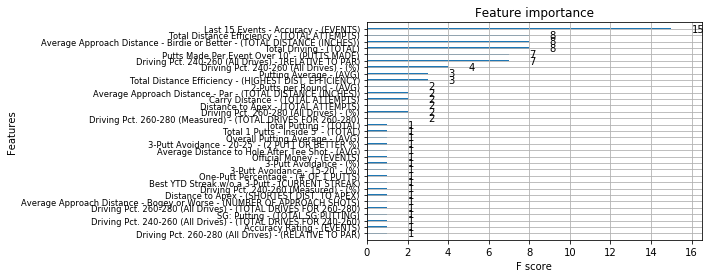

In [16]:
# Plot the results
# create dict 
myfeatures = X_train.columns
dict_features = dict(enumerate(myfeatures))

# feat importance with names f1,f2,...
axsub = xgb.plot_importance(final_gb )

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(myfeatures))
lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

axsub.set_yticklabels(lst_yticklabels, size= 'small')
#print(dict_features)

plt.show()